In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.auto import tqdm
from typing import Optional, Tuple

In [4]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

In [5]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [8]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']])
pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']])

In [9]:
pv = pv.set_index('datetime')

In [41]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,11,30,23,tzinfo=tz)]
pv_val = pv.loc[datetime(2006,11,30,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,20,00,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

# data loader

In [42]:
# Data 1

class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, data_comp, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]
            # print(X.shape)

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]
            # print(Y.shape)

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, 1=power)

        if data_comp==1:
            Y = Y[:,:,0][:,:,None]
            print(Y.shape)

        if data_comp==2:
            X = Y[:,:,1:].copy()
            Y = Y[:,:,0][:,:,None]
            print(X.shape)
            print(Y.shape)
        
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

# model

In [43]:
# weight init 0.01 -> 0.1로 증가

# 뒷부분 padding 제외하는 함수
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding) # 뒷 padding 부분 제거?
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)] 

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [44]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.1)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1.transpose(1, 2))

# wandb

In [15]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 12.4 MB/s 
     |████████████████████████████████| 145 kB 52.3 MB/s 
     |████████████████████████████████| 181 kB 47.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=4df9271e8ce9543d2b9882506352f8f7815e8d786c11898980e4410b467c4da1
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [16]:
import wandb

# data component 1

In [188]:
iw = 24
ow = 24
num_feature = 8

train_dataset = windowDataset(pv_train[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                              input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=ow)
valid_dataset = windowDataset(pv_val[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=ow)
test_dataset = windowDataset(pv_test[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=ow)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

(333, 24, 1)
(20, 24, 1)
(11, 24, 1)


In [189]:
a = next(iter(train_loader))
print(a[0].shape)
print(a[1].shape)

torch.Size([64, 24, 8])
torch.Size([64, 24, 1])


In [190]:
def train(model, train_loader, optimizer, criterion, device='cuda'):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.permute(0,2,1).to(device).float().contiguous()
        y = y.permute(0,2,1).to(device).float().contiguous()

        out = model(x).permute(0,2,1)

        # print(f"x shape: {x.shape}")
        # print(f"y shape: {y.shape}")
        # print(f"pred shape: {out.shape}")
        # print(f"final y shape: {y[:,0,:y.shape[2]].shape}")
        # print(f"final pred shape: {out[:,0,:y.shape[2]].shape}")

        loss = criterion(y[:,0,:y.shape[2]], out[:,0,:y.shape[2]])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        total_loss += loss.cpu().item()
    train_loss = total_loss/len(train_loader)

    return out.detach().cpu().numpy(), y.detach().cpu().numpy(), train_loss

def predict(model, test_loader, criterion, device='cuda', file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []

    for t, (x, y) in enumerate(test_loader):
        x = x.permute(0,2,1).to(device).float()
        y = y.permute(0,2,1).to(device).float()

        with torch.no_grad():
            out = model(x).permute(0,2,1)
        outputs.append(list(out.detach().cpu().numpy()))
        ys.append(list(y.detach().cpu().numpy()))
        loss = criterion(y[:,:,0], out[:,:,0])
        # loss = criterion(y, out)
        total_loss += loss.cpu().item()

    test_loss = total_loss/len(test_loader)
    # print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    if file_name:
        torch.save(model.state_dict(), file_name)

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), test_loss

In [201]:
wandb.init(name='base', project="TCN", entity="yyyyyjkim")

In [202]:
# pv 만 예측하는 경우 output_size=1
# 기상 정보 같이 예측하는 경우 output_size=input_size -> x 

wandb.config = {
    "learning_rate": 0.0001,
    "epochs": 1000,
    "input_size": 8,
    "output_size": 1,
    "num_channels": [10]*8,
    "kernel_size": 5, 
    "dropout": 0.3
}

In [203]:
device='cpu'
model = TCN(input_size=wandb.config['input_size'], output_size=wandb.config['output_size'], num_channels=wandb.config['num_channels'], kernel_size=wandb.config['kernel_size'], dropout=wandb.config['dropout']).to(device)
optimizer = optim.Adam(model.parameters(), lr=wandb.config['learning_rate'])
criterion = nn.MSELoss()

In [204]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,321 trainable parameters


In [205]:
wandb.watch(model, log='all', log_freq=10)

val_loss_min = 100
file_name = 'model/basic.model'

pbar = tqdm(range(wandb.config['epochs']))
for epoch in pbar:
    *result_train, train_loss = train(model, train_loader, optimizer, criterion, device='cpu')
    *result_val, val_loss = predict(model, val_loader, criterion, device='cpu')
    *result_test, test_loss = predict(model, test_loader, criterion, device='cpu')

    if val_loss < val_loss_min:
        val_loss_min = val_loss
        torch.save(model.state_dict(), file_name)
        print(f"epoch: {epoch} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

    wandb.log({"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_loss})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 / val_loss: 0.01373 / test_loss: 0.01385
epoch: 41 / val_loss: 0.01347 / test_loss: 0.01357
epoch: 42 / val_loss: 0.01274 / test_loss: 0.01283
epoch: 43 / val_loss: 0.01212 / test_loss: 0.01221
epoch: 44 / val_loss: 0.01162 / test_loss: 0.01171
epoch: 45 / val_loss: 0.01134 / test_loss: 0.01142
epoch: 46 / val_loss: 0.01059 / test_loss: 0.01067
epoch: 47 / val_loss: 0.00982 / test_loss: 0.00990
epoch: 48 / val_loss: 0.00930 / test_loss: 0.00938
epoch: 49 / val_loss: 0.00884 / test_loss: 0.00891
epoch: 50 / val_loss: 0.00845 / test_loss: 0.00852
epoch: 51 / val_loss: 0.00794 / test_loss: 0.00801
epoch: 52 / val_loss: 0.00741 / test_loss: 0.00747
epoch: 53 / val_loss: 0.00703 / test_loss: 0.00709
epoch: 54 / val_loss: 0.00658 / test_loss: 0.00664
epoch: 55 / val_loss: 0.00630 / test_loss: 0.00636
epoch: 56 / val_loss: 0.00603 / test_loss: 0.00608
epoch: 57 / val_loss: 0.00555 / test_loss: 0.00560
epoch: 58 / val_loss: 0.00520 / test_loss: 0.00525
epoch: 59 / val_loss: 0.00499 / 

In [206]:
wandb.finish()

test_loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.00097
train_loss,0.01281
val_loss,0.00102


In [207]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,0,:ow].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,0,:ow].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

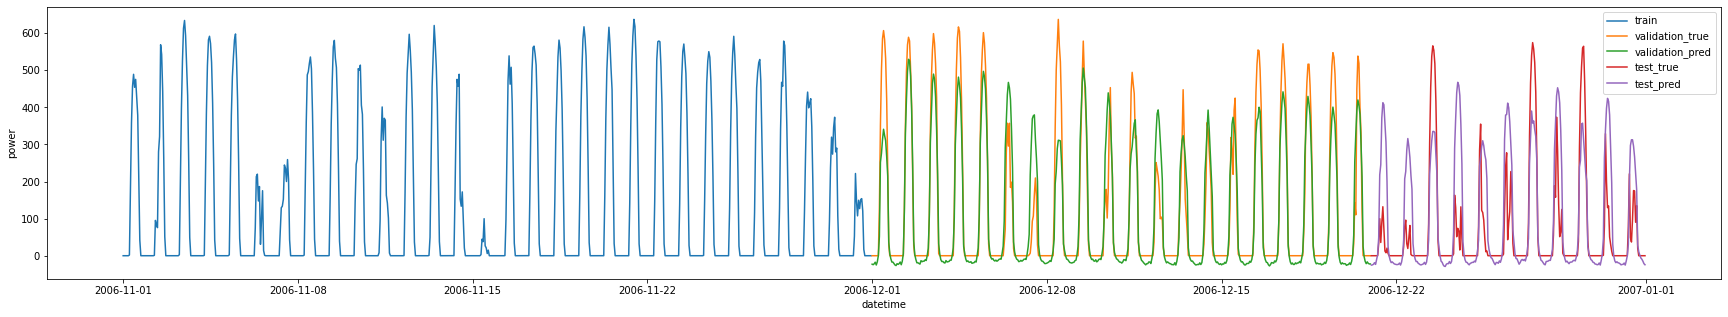

In [208]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'], label='validation_true')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pred_val.reshape(-1), label='validation_pred')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]['power'], label='test_true')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pred_test.reshape(-1), label='test_pred')
plt.legend()

In [209]:
model.load_state_dict(torch.load(file_name))
*result_val, val_loss = predict(model, val_loader, criterion, device='cpu')
*result_test, test_loss = predict(model, test_loader, criterion, device='cpu')

In [210]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,0,:ow].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,0,:ow].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

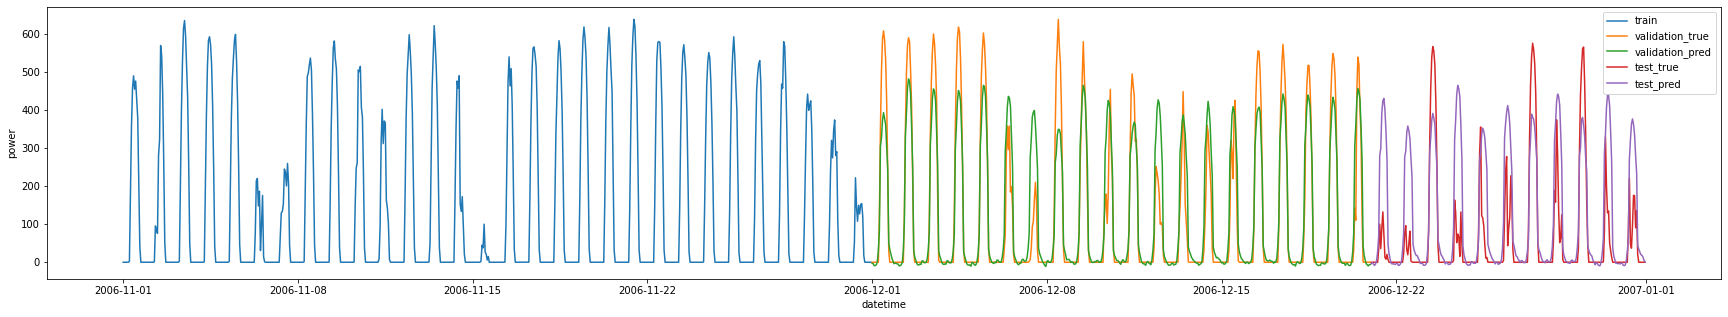

In [211]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'], label='validation_true')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pred_val.reshape(-1), label='validation_pred')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]['power'], label='test_true')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pred_test.reshape(-1), label='test_pred')
plt.legend()

# data component 2

In [135]:
iw = 24
ow = 24
num_feature = 8

train_dataset = windowDataset(pv_train[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                              input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=ow)
valid_dataset = windowDataset(pv_val[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=ow)
test_dataset = windowDataset(pv_test[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=ow)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

(333, 24, 7)
(333, 24, 1)
(20, 24, 7)
(20, 24, 1)
(11, 24, 7)
(11, 24, 1)


In [136]:
a = next(iter(train_loader))
print(a[0].shape)
print(a[1].shape)

torch.Size([64, 24, 7])
torch.Size([64, 24, 1])


In [137]:
def train(model, train_loader, optimizer, criterion, device='cuda'):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.permute(0,2,1).to(device).float().contiguous()
        y = y.permute(0,2,1).to(device).float().contiguous()

        out = model(x).permute(0,2,1)

        # print(f"x shape: {x.shape}")
        # print(f"y shape: {y.shape}")
        # print(f"pred shape: {out.shape}")
        # print(f"final y shape: {y[:,0,:y.shape[2]].shape}")
        # print(f"final pred shape: {out[:,0,:y.shape[2]].shape}")

        loss = criterion(y[:,0,:y.shape[2]], out[:,0,:y.shape[2]])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        total_loss += loss.cpu().item()
    train_loss = total_loss/len(train_loader)

    return out.detach().cpu().numpy(), y.detach().cpu().numpy(), train_loss

def predict(model, test_loader, criterion, device='cuda', file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []

    for t, (x, y) in enumerate(test_loader):
        x = x.permute(0,2,1).to(device).float()
        y = y.permute(0,2,1).to(device).float()

        with torch.no_grad():
            out = model(x).permute(0,2,1)
        outputs.append(list(out.detach().cpu().numpy()))
        ys.append(list(y.detach().cpu().numpy()))
        loss = criterion(y[:,:,0], out[:,:,0])
        # loss = criterion(y, out)
        total_loss += loss.cpu().item()

    test_loss = total_loss/len(test_loader)
    # print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    if file_name:
        torch.save(model.state_dict(), file_name)

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), test_loss

In [176]:
wandb.init(name='base', project="TCN", entity="yyyyyjkim")

In [177]:
# pv 만 예측하는 경우 output_size=1
# 기상 정보 같이 예측하는 경우 output_size=input_size -> x 

wandb.config = {
    "learning_rate": 0.0001,
    "epochs": 1000,
    "input_size": 7,
    "output_size": 1,
    "num_channels": [10]*8,
    "kernel_size": 5, 
    "dropout": 0.3
}

In [178]:
device='cpu'
model = TCN(input_size=wandb.config['input_size'], output_size=wandb.config['output_size'], num_channels=wandb.config['num_channels'], kernel_size=wandb.config['kernel_size'], dropout=wandb.config['dropout']).to(device)
optimizer = optim.Adam(model.parameters(), lr=wandb.config['learning_rate'])
criterion = nn.MSELoss()

In [179]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,261 trainable parameters


In [180]:
wandb.watch(model, log='all', log_freq=10)

val_loss_min = 100
file_name = 'model/basic2.model'

pbar = tqdm(range(wandb.config['epochs']))
for epoch in pbar:
    *result_train, train_loss = train(model, train_loader, optimizer, criterion, device='cpu')
    *result_val, val_loss = predict(model, val_loader, criterion, device='cpu')
    *result_test, test_loss = predict(model, test_loader, criterion, device='cpu')

    if val_loss < val_loss_min:
        val_loss_min = val_loss
        torch.save(model.state_dict(), file_name)
        print(f"epoch: {epoch} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

    wandb.log({"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_loss})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 / val_loss: 0.01843 / test_loss: 0.01845
epoch: 38 / val_loss: 0.01775 / test_loss: 0.01780
epoch: 39 / val_loss: 0.01643 / test_loss: 0.01647
epoch: 40 / val_loss: 0.01529 / test_loss: 0.01534
epoch: 41 / val_loss: 0.01438 / test_loss: 0.01443
epoch: 42 / val_loss: 0.01342 / test_loss: 0.01346
epoch: 43 / val_loss: 0.01272 / test_loss: 0.01275
epoch: 44 / val_loss: 0.01203 / test_loss: 0.01206
epoch: 45 / val_loss: 0.01119 / test_loss: 0.01122
epoch: 46 / val_loss: 0.01014 / test_loss: 0.01019
epoch: 47 / val_loss: 0.00922 / test_loss: 0.00926
epoch: 48 / val_loss: 0.00851 / test_loss: 0.00856
epoch: 49 / val_loss: 0.00813 / test_loss: 0.00818
epoch: 50 / val_loss: 0.00773 / test_loss: 0.00778
epoch: 51 / val_loss: 0.00718 / test_loss: 0.00722
epoch: 52 / val_loss: 0.00673 / test_loss: 0.00677
epoch: 53 / val_loss: 0.00621 / test_loss: 0.00625
epoch: 54 / val_loss: 0.00577 / test_loss: 0.00581
epoch: 55 / val_loss: 0.00552 / test_loss: 0.00556
epoch: 56 / val_loss: 0.00524 / 

In [181]:
wandb.finish()

test_loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,7e-05
train_loss,0.01234
val_loss,7e-05


In [182]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,0,:ow].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,0,:ow].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

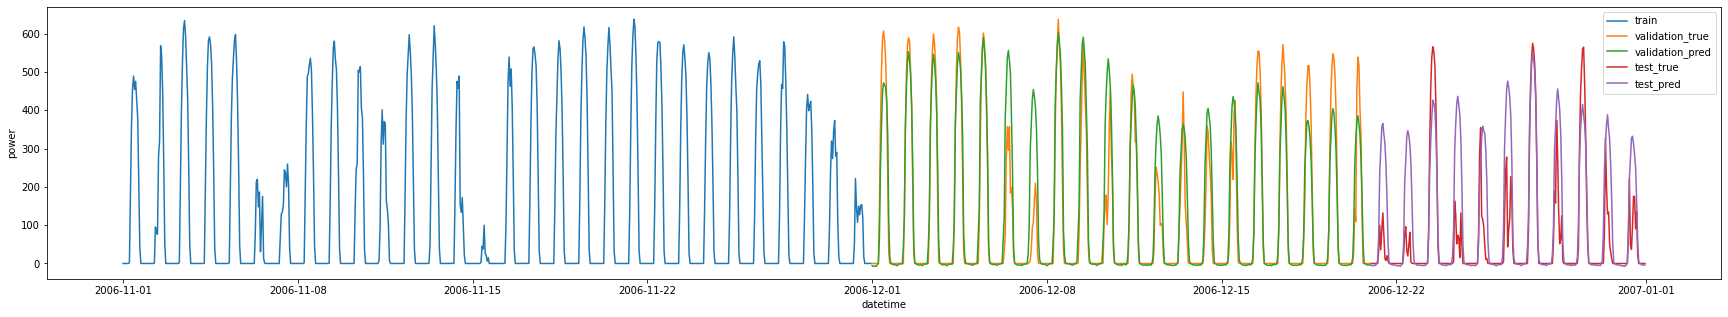

In [183]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'], label='validation_true')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pred_val.reshape(-1), label='validation_pred')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]['power'], label='test_true')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pred_test.reshape(-1), label='test_pred')
plt.legend()

In [184]:
model.load_state_dict(torch.load(file_name))
*result_val, val_loss = predict(model, val_loader, criterion, device='cpu')
*result_test, test_loss = predict(model, test_loader, criterion, device='cpu')

In [185]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,0,:ow].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,0,:ow].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

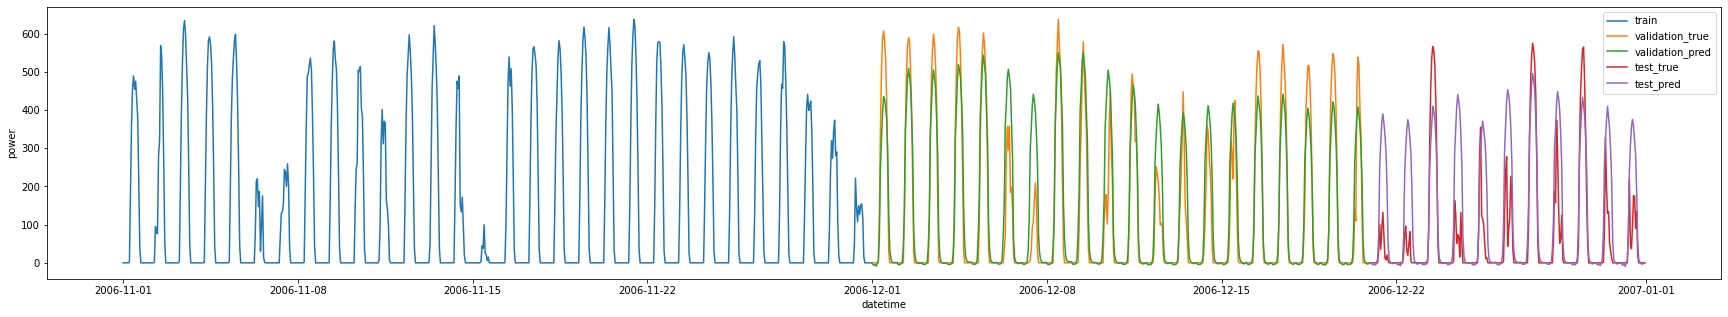

In [186]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'], label='validation_true')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pred_val.reshape(-1), label='validation_pred')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]['power'], label='test_true')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pred_test.reshape(-1), label='test_pred')
plt.legend()